# Part3. DeepFake Detection Model

**Detection모델의 실험 과정의 대표 코드입니다. 본 코드에서는 데이터셋은 Celeb-DF, 모델은 ResNet50, 채널은 Gray Channel을 이용하였습니다.**

### Library Import

In [1]:
!pip install pytorch-lightning
!pip install lightning-bolts
!pip install torch_summary

   ---------------------------------------- 0.0/802.3 kB ? eta -:--:--
   ------------ --------------------------- 245.8/802.3 kB 7.4 MB/s eta 0:00:01
   ---------------------------- ----------- 573.4/802.3 kB 7.2 MB/s eta 0:00:01
   ---------------------------------------- 802.3/802.3 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/868.8 kB ? eta -:--:--
   ------------ -------------------------- 276.5/868.8 kB 16.6 MB/s eta 0:00:01
   --------------------------------------  860.2/868.8 kB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 868.8/868.8 kB 9.1 MB/s eta 0:00:00
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/300.8 kB ? eta -:--:--
   ------------------------------- -------- 235.5/300.8 kB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 300.8/300.8 kB 6.2 MB/s eta 0:00:00
   

In [1]:
# 데이터 보기
import pandas as pd
import numpy as np
from glob import glob

# 이미지데이터 로딩
from PIL import Image
import cv2
from tqdm import tqdm

# random
import random

# 파일경로 설정
import os
import json

# Others
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt


# torch
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import datasets, models, transforms
from random import seed,shuffle
from torch import nn
import torch.nn.functional as F
from torchsummary import summary


### DataPath 설정

In [2]:
data_path = 'datasets/Celeb-DF-v2'

real_path = data_path + '/Celeb-real' 
fake_path = data_path + '/Celeb-synthesis'

In [3]:
from glob import glob
VIDEO_PATH_REAL_LIST = glob(real_path+'/*')+ glob('./Youtube-real/*/*.jpg')
VIDEO_PATH_FAKE_LIST = glob(fake_path+'/*')

VIDEO_PATH_FULL_LIST = VIDEO_PATH_REAL_LIST + VIDEO_PATH_FAKE_LIST

### Dataset

In [4]:
def VideoFrames(video_path_list):
    video_lists = []
    for i in video_path_list :
        video_lists.append(sorted(glob(i+'/*'))[:5])
    return video_lists

# function of that a video transform to iamges (with path)

In [5]:
for i in VideoFrames(VIDEO_PATH_FULL_LIST):
    if len(i) != 5:
        print(len(i))
        print(i)
        #/Celeb-real/id27_0005/00000.jpg

1
['datasets/Celeb-DF-v2/Celeb-real\\id27_0005\\00000.jpg']


In [6]:
VIDEO_PATH_FULL_LIST.remove('datasets/Celeb-DF-v2/Celeb-real\\id27_0005')

In [7]:
class CelebDfDataset4D(Dataset):
    def __init__ (self, video_path_list, transform=None): # numFrames = 50
        # self.path_list = data_path_list 
        self.video_list = video_path_list
        self.transform = transform
        # self.count = numFrames
        seed(10)
        shuffle(self.video_list)

        self.VideoFrameList = VideoFrames(self.video_list)

        self.label = [1.0 if video.split('-')[-1].startswith('real') else 0.0 for video in self.video_list] 

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        # for recurrent network
        video_path = self.video_list[idx]
        frames = []
        if torch.is_tensor(idx):
            idx = idx.tolist()

        for i,frame in enumerate(self.VideoFrameList[idx]):
            frame = cv2.imread(frame)[:,:,::-1] 

            
            frames.append(self.transform(frame))
        
        frames = torch.stack(frames)    
        label  = self.label[idx]

        return torch.tensor(frames/255).to(device), torch.tensor(label).to(device) # 근데 device로 보내는거 안해도됨???



In [8]:
shuffle(VIDEO_PATH_FULL_LIST)

In [9]:
train_videos = VIDEO_PATH_FULL_LIST[:int(0.8*len(VIDEO_PATH_FULL_LIST))]
test_videos = VIDEO_PATH_FULL_LIST[int(0.8*len(VIDEO_PATH_FULL_LIST)):]

In [10]:
# map을 통해서 각 리스트에서 조건에 맞춰서 1 0으로 바꾼다음에 개수 세면 될 듯
def num_real_fake(videos) :
    realfake = list(map(lambda x: 1 if 'real' in x else 0 ,videos))
    num_real = realfake.count(1)
    num_fake = len(realfake) - num_real
    return num_real, num_fake

In [11]:
num_real_fake(train_videos)

(471, 2380)

In [12]:
num_real_fake(test_videos)

(118, 595)

In [13]:
# load the labels and video in data loader

im_size = 224
mean = [0.485]
std = [0.229]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std),
                                        transforms.Grayscale(num_output_channels=3)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std),
                                        transforms.Grayscale(num_output_channels=3)])
train_data = CelebDfDataset4D(train_videos,transform = train_transforms)
test_data = CelebDfDataset4D(test_videos,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 1,shuffle = False)

test_loader = DataLoader(test_data,batch_size = 1,shuffle = False)


In [14]:
MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device)
STD = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [15]:
def custom_imshow(img):
    
    img = img*255
    img = img * STD[:, None, None] + MEAN[:, None, None]
    img = img.cpu().numpy()

    plt.imshow(np.transpose(img, (1, 2, 0))) 
    plt.show()

### Dataset 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 224, 224])


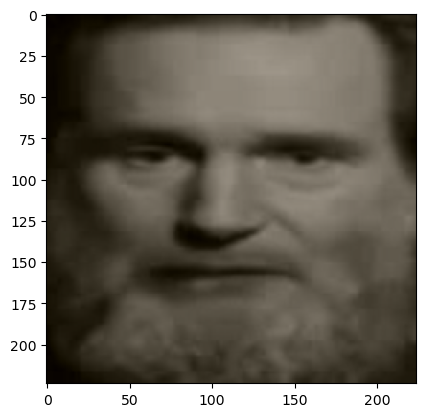

In [16]:
images,label = train_data[0]
print(images.shape) # numframes channels, width, height)
custom_imshow(images[0,:,:,:])

### get model

In [18]:
class Model(nn.Module):

    def __init__(self):
        super().__init__()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [21]:
class EncoderDecoder(Model):

    def __init__(self, encoder, decoder, activation, classifier):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

        if callable(activation) or activation is None:
            self.activation = activation
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError('Activation should be "sigmoid"/"softmax"/callable/None')

    def forward(self, x):
        """Sequentially pass `x` trough model`s `encoder` and `decoder` (return logits!)"""
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w) 
        x0 = self.encoder.conv1(x)
        x0 = self.encoder.bn1(x0)
        x0 = self.encoder.relu(x0)

        x1 = self.encoder.maxpool(x0)
        x1 = self.encoder.layer1(x1)

        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x4 = self.encoder.layer4(x3)

        x = self.decoder([x4, x3, x2, x1, x0])
        x = self.classifier(x)
        return x

In [22]:
class Conv3x3GNReLU(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, (3, 3),
                      stride=1, padding=1, bias=False),
            nn.GroupNorm(32, out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        return x


In [23]:
class FPNBlock(nn.Module):
    def __init__(self, pyramid_channels, skip_channels):
        super().__init__()
        self.skip_conv = nn.Conv2d(skip_channels, pyramid_channels, kernel_size=1)

    def forward(self, x):
        x, skip = x

        x = F.interpolate(x, scale_factor=2, mode='nearest')
        skip = self.skip_conv(skip)

        x = x + skip
        return x

In [24]:
class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()

        blocks = [
            Conv3x3GNReLU(in_channels, out_channels, upsample=bool(n_upsamples))
        ]

        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(Conv3x3GNReLU(out_channels, out_channels, upsample=True))

        self.block = nn.Sequential(*blocks)

    def forward(self, x):
        return self.block(x)


In [25]:
class FPNDecoder(Model):

    def __init__(
            self,
            encoder_channels,
            pyramid_channels=64,
            segmentation_channels=32,
            final_upsampling=4,
            final_channels=3,
            dropout=0.2,
            merge_policy='add'
    ):
        super().__init__()

        if merge_policy not in ['add', 'cat']:
            raise ValueError("`merge_policy` must be one of: ['add', 'cat'], got {}".format(merge_policy))
        self.merge_policy = merge_policy

        self.final_upsampling = final_upsampling
        self.conv1 = nn.Conv2d(encoder_channels[1], pyramid_channels, kernel_size=(1, 1))

        self.p4 = FPNBlock(pyramid_channels, encoder_channels[2])
        self.p3 = FPNBlock(pyramid_channels, encoder_channels[3])
        self.p2 = FPNBlock(pyramid_channels, encoder_channels[4])

        self.s5 = SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=3)
        self.s4 = SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=2)
        self.s3 = SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=1)
        self.s2 = SegmentationBlock(pyramid_channels, segmentation_channels, n_upsamples=0)

        self.dropout = nn.Dropout2d(p=dropout, inplace=True)

        if self.merge_policy == 'cat':
            segmentation_channels *= 4

        self.final_conv = nn.Conv2d(segmentation_channels, final_channels, kernel_size=1, padding=0)

        self.initialize()

    def forward(self, x):
        c5, c4, c3, c2, _ = x

        p5 = self.conv1(c5)
        p4 = self.p4([p5, c4])
        p3 = self.p3([p4, c3])
        p2 = self.p2([p3, c2])

        s5 = self.s5(p5)
        s4 = self.s4(p4)
        s3 = self.s3(p3)
        s2 = self.s2(p2)

        if self.merge_policy == 'add':
            x = s5 + s4 + s3 + s2
        elif self.merge_policy == 'cat':
            x = torch.cat([s5, s4, s3, s2], dim=1)

        x = self.dropout(x)
        x = self.final_conv(x)

        if self.final_upsampling is not None and self.final_upsampling > 1:
            x = F.interpolate(x, scale_factor=self.final_upsampling, mode='bilinear', align_corners=True)
        return x

In [26]:
class swin3d_transformer(Model):
    def __init__(
            self,
            num_classes = 2
    ):
        super().__init__()

        self.swin3d = models.video.swin_transformer.swin3d_t()
        self.linear = nn.Linear(400,num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = x.permute(1,0,2,3).unsqueeze(0)
        x = self.swin3d(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        x = x.to(torch.float32)
        return x

In [27]:
class FPN(EncoderDecoder):
    def __init__(
            self,
            encoder_name='resnet50',
            pretrained=True,
            decoder_pyramid_channels=256,
            decoder_segmentation_channels=256,
            classes=1,
            dropout=0.2,
            activation=None,
            final_upsampling=4,
            decoder_merge_policy='add',
            resnet50_ = 'weights/gray_200epochs_resnet50.tar'
    ):
        # get encoder - resnext50
        # encoder = torchvision.models.resnext50_32x4d(pretrained=pretrained)

        encoder = self.load_model(resnet50_)
        #filters_dict = [512, 512, 256, 128, 64]
        filters_dict = [2048, 2048, 1024, 512, 256]
        encoder.out_shapes = filters_dict

        decoder = FPNDecoder(
            encoder_channels=encoder.out_shapes,
            pyramid_channels=decoder_pyramid_channels,
            segmentation_channels=decoder_segmentation_channels,
            final_channels=3,
            dropout=dropout,
            final_upsampling=final_upsampling,
            merge_policy=decoder_merge_policy
        )

        classifier = swin3d_transformer(
            num_classes = classes
        )

        super().__init__(encoder, decoder, activation, classifier)

        self.name = 'fpn-{}'.format(encoder_name)

    def load_model(self,path):
        model = models.resnet50(pretrained=False)
        checkpoint = torch.load(path)
        for key in list(checkpoint['state_dict'].keys()):
            name=('.').join(key.split('.')[1:])
            checkpoint['state_dict'][name]=checkpoint['state_dict'].pop(key)
            # 딕셔너리 키 값 변경하기
        model.load_state_dict(checkpoint['state_dict'],strict=False)
        return model

In [28]:
FPN()

FPN(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [29]:
full_model = FPN().to(device)
x = torch.randn(1,10, 3, 224, 224).to(device)
output = full_model(x)
print(output.size())

torch.Size([1, 1])


In [30]:
imus = images.unsqueeze(0)
imus.shape

torch.Size([1, 5, 3, 224, 224])

In [31]:
zero_ims = torch.zeros_like(imus).to(device)
fpn_output = full_model(zero_ims)
fpn_output

tensor([[0.5554]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [32]:
#GPU 정리
import gc
gc.collect()
torch.cuda.empty_cache()

### for train

In [45]:
lr = 0.001 #learning rate
num_epochs = 5 #학습할 epoch 수
optimizer = torch.optim.AdamW(full_model.parameters(), lr=lr) #Gradient Descent 에 적용할 Activation 함수
loss_function = nn.BCELoss().to(device) #model의 성능을 측정하고 학습 현황을 보여줄 목적함수

In [46]:
params = {
    'optimizer':optimizer,
    'loss_function': loss_function,
    'train_dataloader':train_loader,
    'test_dataloader': test_loader,
    'device':device
}

In [47]:
def train(model,params=params):
    loss_function=params['loss_function']
    train_dataloader=params['train_dataloader']
    test_dataloader=params['test_dataloader']
    device=params['device']

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    #epoch 횟수 만큼 학습
    for epoch in range(0,num_epochs): 
        for i,data in enumerate(tqdm(train_dataloader),0):
            model.train()
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            #이전 배치의 가중치 초기화
            optimizer.zero_grad()

            #feedforward 그리고 backpropagation
            output = torch.squeeze(model(inputs),1)
            train_loss = loss_function(output,labels)
            train_loss.backward()
            
            #가중치 업데이트
            optimizer.step()
            optimizer.zero_grad()


        total = 0
        correct = 0
        accuracy = []
        for i,data in enumerate(test_dataloader,0):
            model.eval()
            inputs,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = torch.squeeze(model(inputs),1)

            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss = loss_function(outputs,labels)
            accuracy.append(100*correct/total)

        print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy %.2f' % (epoch+1,num_epochs,train_loss.item(),test_loss.item(),100*correct/total))

### Train

In [48]:
train(model=full_model, params=params)

100%|██████████████████████████████████████████████████████████████████████████████| 2851/2851 [02:52<00:00, 16.52it/s]


Epoch: 1/5, Train loss: 0.227465, Test loss: 0.226762, Accuracy 83.45


100%|██████████████████████████████████████████████████████████████████████████████| 2851/2851 [02:56<00:00, 16.14it/s]


Epoch: 2/5, Train loss: 0.263068, Test loss: 0.259212, Accuracy 83.45


100%|██████████████████████████████████████████████████████████████████████████████| 2851/2851 [02:51<00:00, 16.60it/s]


Epoch: 3/5, Train loss: 0.258985, Test loss: 0.256304, Accuracy 83.45


100%|██████████████████████████████████████████████████████████████████████████████| 2851/2851 [02:57<00:00, 16.03it/s]


Epoch: 4/5, Train loss: 0.259907, Test loss: 0.256961, Accuracy 83.45


100%|██████████████████████████████████████████████████████████████████████████████| 2851/2851 [02:56<00:00, 16.18it/s]


Epoch: 5/5, Train loss: 0.247517, Test loss: 0.246457, Accuracy 83.45


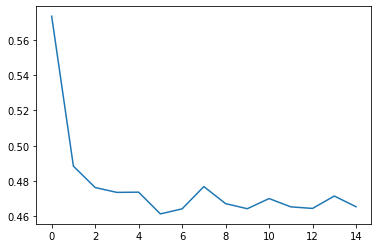

In [60]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

In [61]:
import time
start = time.time()

for ix, batch in enumerate(iter(test_loader)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)     
    val_epoch_accuracies.extend(val_is_correct)
val_accuracy_list = []

for i in val_epoch_accuracies:
    batch_mean = np.sum(i)
    val_accuracy_list.append(batch_mean)
val_epoch_accuracy = sum(val_accuracy_list)/(batchsize*len(val_accuracy_list))


print('val_epoch_accuracy : ',  val_epoch_accuracy)

print("time :", time.time() - start)

val_epoch_accuracy :  0.9117174959871589
time : 212.71361565589905
